## Importing 

In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
import astropy.units as u
from IPython.core.display import display,HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from tqdm.notebook import tqdm

In [4]:
gnom_proj_file = fits.open("/data/cassegrain/HI4Pi/TAN/TAN_E01.fits")

In [5]:
gnom_proj_file.info()

Filename: /data/cassegrain/HI4Pi/TAN/TAN_E01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (269, 274, 933)   float32   


In [6]:
gnom_proj_hdu = gnom_proj_file[0]

In [7]:
gnom_proj_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  269                                                  
NAXIS2  =                  274                                                  
NAXIS3  =                  933                                                  
OBJECT  = 'HI4PI   '           / The HI 4-PI Survey                             
TELESCOP= 'Effelsberg 100m RT; ATNF Parkes 64-m' / Telescope names              
ORIGIN  = 'AIfA/MPIfR Bonn; ATNF Sydney' / Organisations or Institutions        
REFERENC= 'HI4PI Collaboration 2016' / A&A                                      
RESTFRQ =        1420405751.77                                                  
RESTWAV =       0.211061140541                                                  
WCSAXES =                   

In [8]:
gnom_proj_data = gnom_proj_hdu.data

In [9]:
gnom_proj_data.shape

(933, 274, 269)

In [ ]:
map=[]

for i,filename in tqdm(
    enumerate(os.listdir('/data/cassegrain/HI4Pi/HEALPix/'))
                      ):
    files_map=hp.read_map('/data/cassegrain/HI4Pi/HEALPix/'+filename,field="DATA", partial=True, wavel=467)
    files_map[files_map == bg]=0
    if i == 0:
        map_tot=files_map
    else:
        map_tot=map_tot+files_map
    fil=fits.open('/data/cassegrain/HI4Pi/HEALPix/'+filename)
    clon = np.median(fil[1].data.field("GLON"))
    clat = np.median(fil[1].data.field("GLAT"))
    
hp.mollview(map_tot, xsize=4000, coord="G", unit="Density", title="Mollweide view for HI4PI")
hp.graticule()

<Figure size 720x432 with 0 Axes>

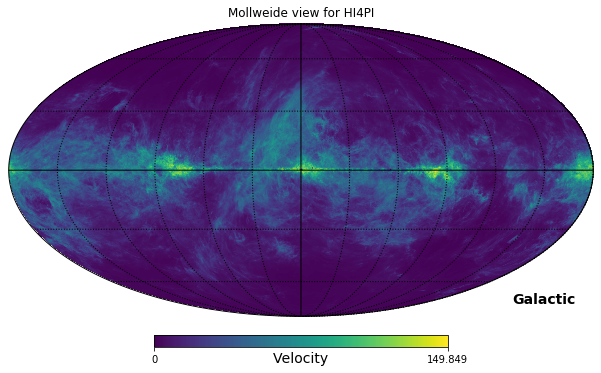

In [162]:
hp.mollview(map_tot, xsize=4000, coord="G", unit="Density", title="Mollweide view for HI4PI")
hp.graticule()

## Rotational curve

#### Tangent method - The velocity at los is the largest
<img src='WeChat Image_20200218132206.jpg' width="400">

In [16]:
def loadfits(filename): 
    '''
    Return the HDU,central pixel wavelength and velocity gradient.
    '''
    file = fits.open('/data/cassegrain/HI4Pi/HEALPix/'+filename)
    HDU = file[1]
    vel_grd = HDU.header['1CDLT6']         # Velocity gredient
    cen_pix = '%3d'%(HDU.header['1CRPX6']) 
    return HDU,cen_pix,vel_grd

def cvt2vel(f,filename):
    '''
    Convert the bin indices of pixels to velocity
    '''
    HDU,cen_pix,vel_grd = loadfits(filename)
    vel = (f-int(cen_pix)) * vel_grd
    return vel

def cvt2tot_v(v,l):
    '''
    Convert the velocity from solar local frame to  galatic frame. Unit:m/s
    '''
    v_sun = 200e3 
    v_tot = v+v_sun*np.sin(np.pi*l/180)
    return v_tot

def arg_velmax(filename,noise_thread = 3):
    '''
    Args:
    filename: the fits file to open.
    noise_thread: the back noise level in antena temperature. Suggested to be 5.This means temperature must be above 5 to be considered.
    
    Return:
    return the list of pixel number and the frequency of the highest velocity above the threadhold. 
    '''
    fqcs,indexs = [],[]

    HDU,_,_ = loadfits(filename)
    index = np.argwhere(HDU.data.field("GLAT") == 0)
    index = [i[0] for i in index] ## the args index for where the maximum frequency is found
    
    for idx in index:
        if np.argwhere(
            HDU.data['DATA'][idx]> noise_thread
        ).size > 0:
            arg = np.argwhere(HDU.data['DATA'][idx]> noise_thread).max()
#             max_fqc = HDU.data['DATA'][idx][arg]
            
            fqcs.append(arg)
            indexs.append(idx)
            
    return np.array(indexs),np.array(fqcs)

def arg_velmin(filename,noise_thread = 3):
    '''
    Args:
    filename: the fits file to open.
    noise_thread: the back noise level in antena temperature. Suggested to be 5.This means temperature must be above 5 to be considered.
    
    Return:
    return the list of pixel number and the frequency of the highest velocity above the threadhold. 
    '''
    fqcs,indexs = [],[]

    HDU,_,_ = loadfits(filename)
    index = np.argwhere(HDU.data.field("GLAT") == 0)
    index = [i[0] for i in index] ## the args index for where the maximum frequency is found
    
    for idx in index:
        if np.argwhere(
            HDU.data['DATA'][idx]> noise_thread
        ).size > 0:
            arg = np.argwhere(HDU.data['DATA'][idx]> noise_thread).min()
#             max_fqc = HDU.data['DATA'][idx][arg]
            
            fqcs.append(arg)
            indexs.append(idx)
            
    return np.array(indexs),np.array(fqcs)

### Filter out the files that included the galatic plane

In [235]:
gala_plane_pixel = []
for filename in os.listdir('/data/cassegrain/HI4Pi/HEALPix/'):
    file = fits.open('/data/cassegrain/HI4Pi/HEALPix/'+filename)

    glon_min = np.min(file[1].data.field("GLON"))
    glon_max = np.max(file[1].data.field("GLON"))
    glat_min = np.min(file[1].data.field("GLAT"))
    glat_max = np.max(file[1].data.field("GLAT"))
    
#     if (glon_max < 90) and (glat_max * glat_min <= 0):
    if (glon_max < 90 or glon_max > 270) and (glat_max * glat_min <= 0):
        print('The range of GLON, GLAT of %s is (%2d,%2d) and (%2d %2d)'%(filename, np.min(file[1].data.field("GLON")),np.max(file[1].data.field("GLON")),np.min(file[1].data.field("GLAT")),np.max(file[1].data.field("GLAT"))))
        gala_plane_pixel.append(filename)

The range of GLON, GLAT of HPX_101.fits is (270,292) and (-9  9)
The range of GLON, GLAT of HPX_090.fits is (22,44) and (-9  9)
The range of GLON, GLAT of HPX_104.fits is (337,359) and (-9  9)
The range of GLON, GLAT of HPX_089.fits is ( 0,22) and (-9  9)
The range of GLON, GLAT of HPX_091.fits is (45,67) and (-9  9)
The range of GLON, GLAT of HPX_102.fits is (292,314) and (-9  9)
The range of GLON, GLAT of HPX_103.fits is (315,337) and (-9  9)
The range of GLON, GLAT of HPX_092.fits is (67,89) and (-9  9)


#### Find the highest frequency and pixel index in order to have sth to transfer to velocity

In [137]:
HDU.data.field('GLON').shape

(65536,)

In [168]:
filename = 'HPX_104.fits'

idc,f = arg_velmax(filename,noise_thread)
HDU,_,_ = loadfits(filename)

GLON = HDU.data.field('GLON')[idc]
GLAT = HDU.data.field('GLAT')[idc]

f.shape
GLON.shape

/local/environments/obs/obs-python36/lib64/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/local/environments/obs/obs-python36/lib64/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


(254,)

/local/environments/obs/obs-python36/lib64/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/local/environments/obs/obs-python36/lib64/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


finished


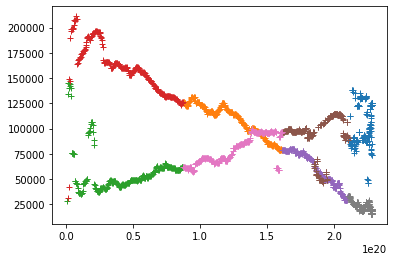

In [249]:
files,vels,Ds= [],[],[]

noise_thread = 10

R0 = 2.28340141e20

for filename in gala_plane_pixel:
# for filename in ['HPX_089.fits','HPX_090.fits','HPX_091.fits','HPX_092.fits']:
# for filename in ['HPX_101.fits','HPX_102.fits','HPX_103.fits','HPX_104.fits']:
    idc,f = arg_velmax(filename,noise_thread)
    HDU,_,_ = loadfits(filename)
    
    GLON = HDU.data.field('GLON')[idc]
    GLAT = HDU.data.field('GLAT')[idc]
    
    max_vels = np.array([cvt2vel(f,filename) for f in f])
    
    D = np.array([np.abs(R0*np.sin(np.pi*GLON/180)) for GLON in GLON])
    
#     print(
#         'For %s, the highest velocity is found at %s, %s kpc away'%(filename,vel,D)
#     )
#     plt.figure()
#     plt.title(filename)
#     plt.plot(D,max_vels)
    
    plt.plot(D,max_vels,'+')
    
    files.append(filename)
    vels.append(max_vels)
    Ds.append(D)
print('finished')
# for d in Ds:
#     plt.plot(d)

In [262]:
a = np.array([1,2,3])
b = np.array([3,2,1])
[a+b for a,b in zip(a,b)]

[4, 4, 4]

/local/environments/obs/obs-python36/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/local/environments/obs/obs-python36/lib64/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater


finished


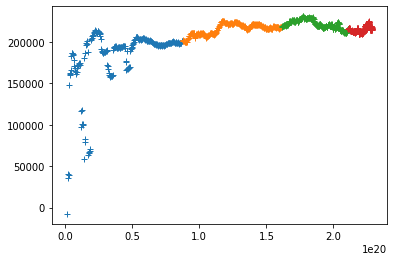

In [44]:
files,vels,Ds= [],[],[]

noise_thread = 13.5

R0 = 2.28340141e20
for filename in ['HPX_089.fits','HPX_090.fits','HPX_091.fits','HPX_092.fits']:#0-90
    idc,f = arg_velmax(filename,noise_thread)
    HDU,_,_ = loadfits(filename)
    
    GLON = HDU.data.field('GLON')[idc]
    GLAT = HDU.data.field('GLAT')[idc]
    
    max_vels = np.array([cvt2vel(f,filename) for f in f]) #cvt from frequency to velocity
    
    max_vels = np.array([cvt2tot_v(v,l) for v,l in zip(max_vels, GLON)]) #cvt from local vel to total vel respect to the galaxy
    
    D = np.array([np.abs(R0*np.sin(np.pi*GLON/180)) for GLON in GLON])
    
#     print(
#         'For %s, the highest velocity is found at %s, %s kpc away'%(filename,vel,D)
#     )
#     plt.figure()
#     plt.title(filename)
#     plt.plot(D,max_vels)
    
    plt.plot(D,max_vels,'+')
    
    files.append(filename)
    vels.append(max_vels)
    Ds.append(D)
print('finished')

/local/environments/obs/obs-python36/lib64/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater
/local/environments/obs/obs-python36/lib64/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater


finished


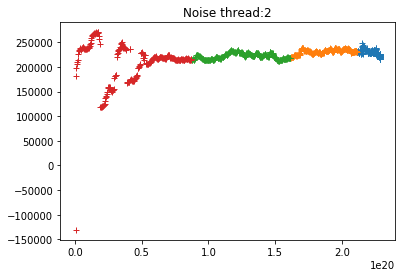

In [61]:
#TODO: Find the best threadhold value by investigating the noise distribution.

files,vels,Ds= [],[],[]

# for noise_thread in np.linspace(2,10,18):

noise_thread = 2

R0 = 2.28340141e20
for filename in ['HPX_101.fits','HPX_102.fits','HPX_103.fits','HPX_104.fits']: #270-360
    idc,f = arg_velmin(filename,noise_thread)
    HDU,_,_ = loadfits(filename)

    GLON = HDU.data.field('GLON')[idc]
    GLAT = HDU.data.field('GLAT')[idc]

    min_vels = np.array([cvt2vel(f,filename) for f in f]) #cvt from frequency to velocity

    min_vels = np.array([cvt2tot_v(v,l) for v,l in zip(min_vels, GLON)]) #cvt from local vel to total vel respect to the galaxy

    D = np.array([np.abs(R0*np.sin(np.pi*GLON/180)) for GLON in GLON])

    plt.plot(D,-min_vels,'+') #add a minus bc sin function....
    plt.title('Noise thread:'+str(noise_thread))

    files.append(filename)
    vels.append(min_vels)
    Ds.append(D)
print('finished')

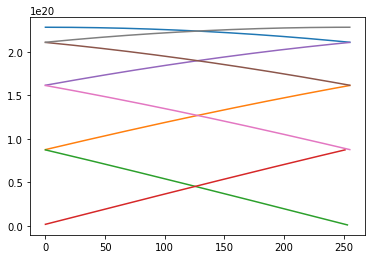

In [231]:
for Ds in Ds:
    plt.plot(Ds)

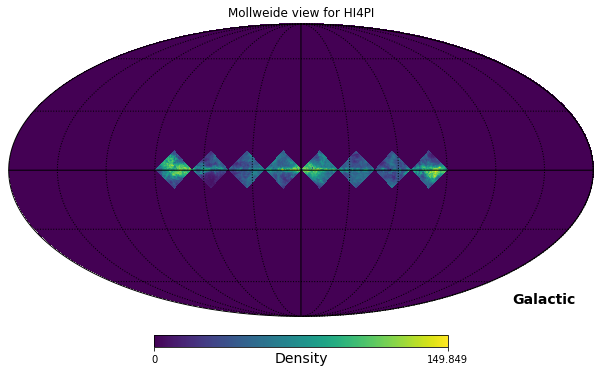

In [20]:
map=[]

for i,filename in enumerate(files):
    files_map=hp.read_map('/data/cassegrain/HI4Pi/HEALPix/'+filename,field="DATA", partial=True, wavel=467)
    files_map[files_map <= 0]=0
    if i == 0:
        map_tot=files_map
    else:
        map_tot=map_tot+files_map
    fil=fits.open('/data/cassegrain/HI4Pi/HEALPix/'+filename)
    
hp.mollview(map_tot, xsize=4000, coord="G", unit="Density", title="Mollweide view for HI4PI")
hp.graticule()

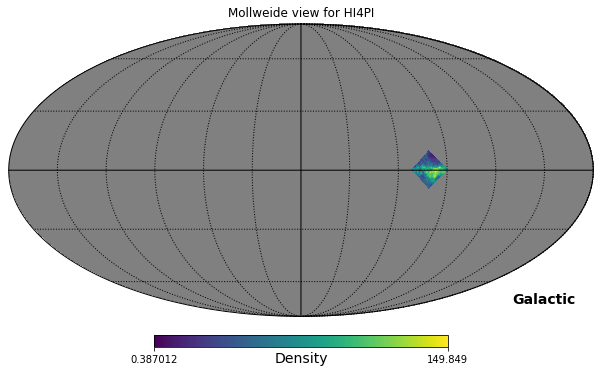

In [18]:
mp = hp.read_map("/data/cassegrain/HI4Pi/HEALPix/HPX_101.fits", field="DATA", wavel=467)
hp.mollview(mp, xsize=4000, coord="G", unit="Density", title="Mollweide view for HI4PI")
hp.graticule()

In [121]:
order = np.argsort(np.abs(Ds))
Ds = np.array(np.abs(Ds))
Ds[order]

array([0.39281684, 2.04252836, 4.27777778, 7.06750082, 7.39819682,
       7.43227501, 7.6013922 , 8.10568917])

In [99]:
rc = np.zeros((len(Ds),2))
for i in range(len(Ds)):
    x = (np.abs(Ds[i]),vels[i])
    rc[i] = x

In [101]:
rc

array([[7.60139220e+00, 1.52009366e+05],
       [3.92816840e-01, 1.44280077e+05],
       [8.10568917e+00, 1.77773666e+05],
       [4.27777778e+00, 2.79542648e+05],
       [7.43227501e+00, 9.66161227e+04],
       [7.39819682e+00, 2.26725835e+05],
       [7.06750082e+00, 1.12074702e+05],
       [2.04252836e+00, 6.69871784e+04]])

In [116]:
rc = rc[np.argsort(rc[:,0])]
rc[:,1]

array([144280.07654191,  66987.17839446, 279542.64829995, 112074.70231381,
       226725.83456586,  96616.12268432, 152009.36635666, 177773.66573914])

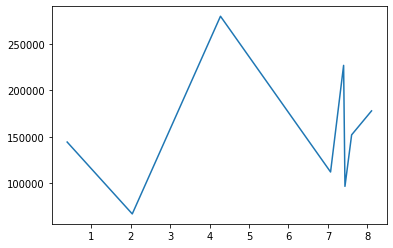

In [113]:
plt.figure()
x,y = rc[:,0],rc[:,1]
plt.plot(x,y)

In [56]:
y

array([0.39281684, 2.04252836, 4.27777778, 7.06750082, 7.39819682,
       7.43227501, 7.6013922 , 8.10568917])

### Example of Spectrums 

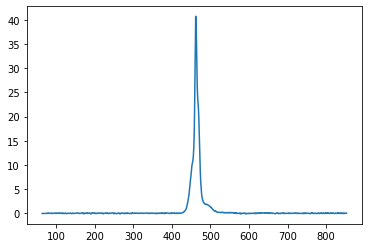

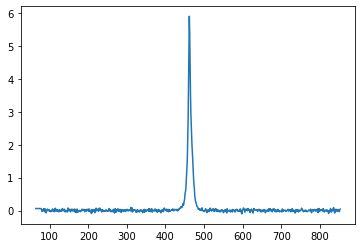

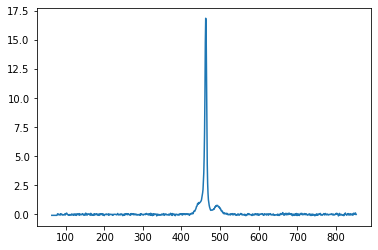

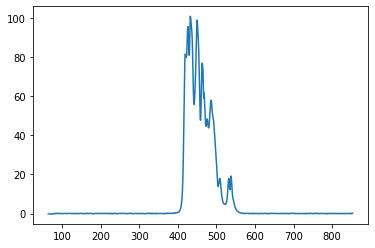

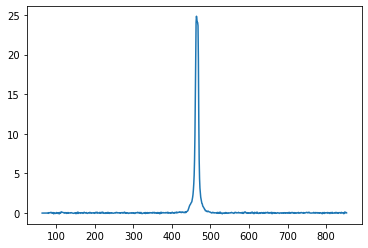

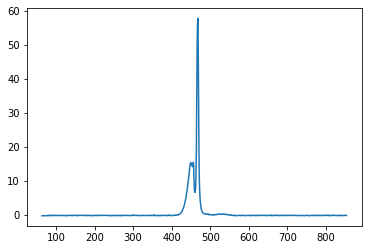

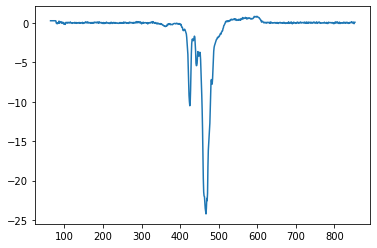

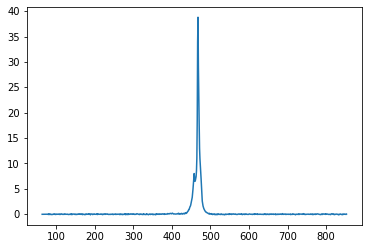

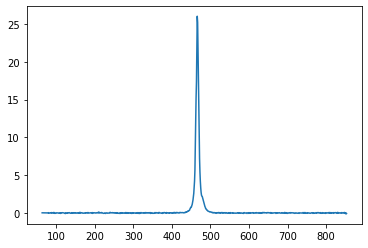

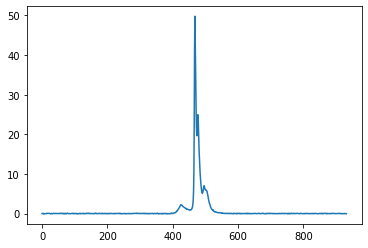

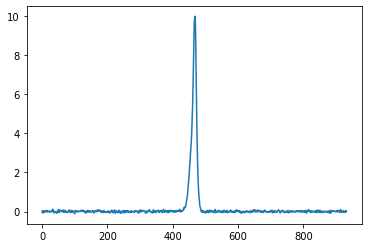

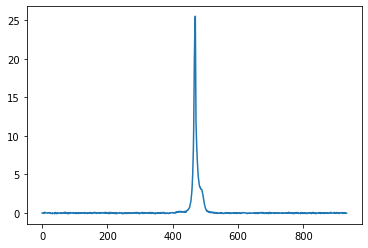

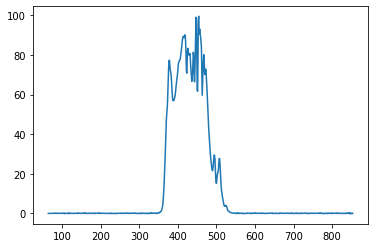

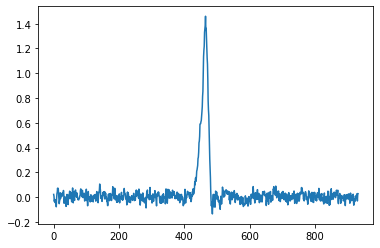

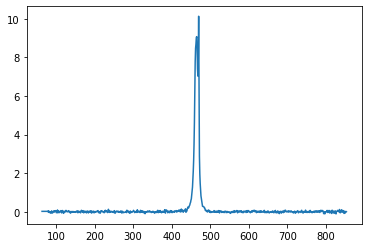

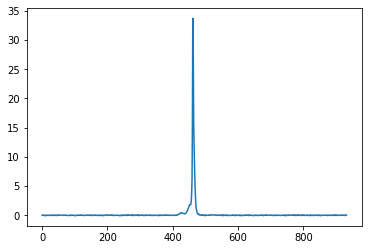

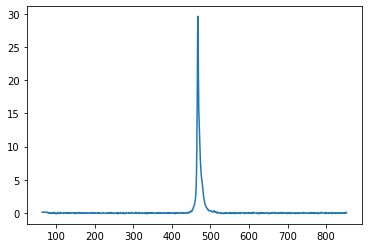

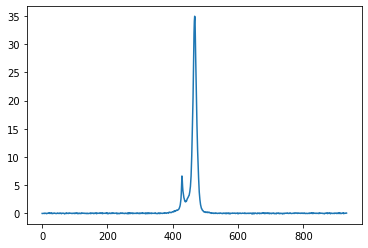

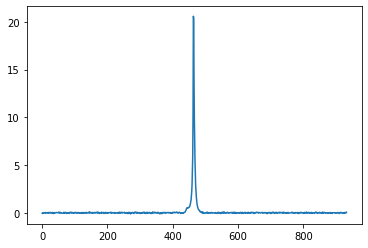

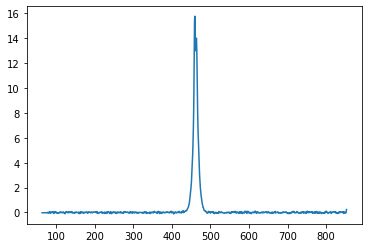

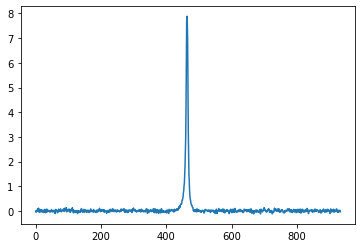

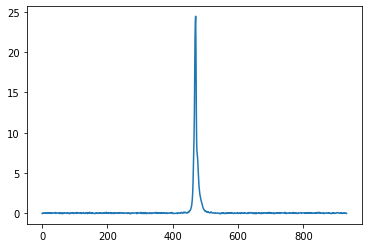

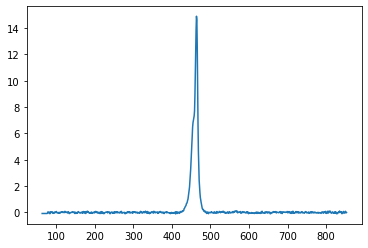

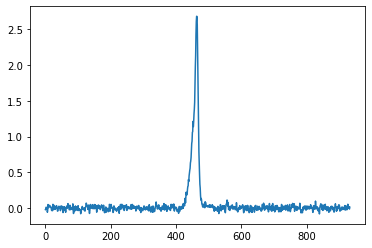

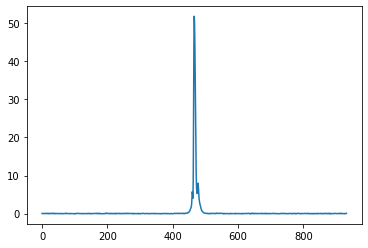

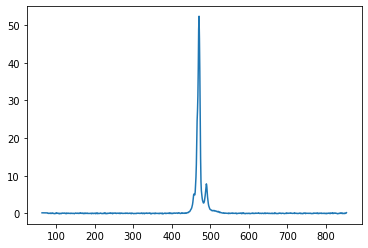

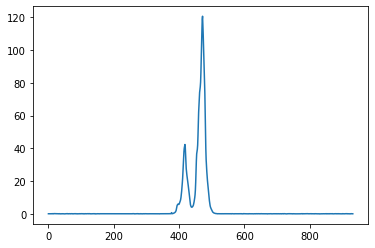

KeyboardInterrupt: 

In [6]:
for filename in os.listdir('/data/cassegrain/HI4Pi/HEALPix/'):
    file = fits.open('/data/cassegrain/HI4Pi/HEALPix/'+filename)
    HDU = file[1]
    GLON_max = np.max(file[1].data.field("GLON"))
#     GLAT_min, GLAT_max = np.min(file[1].data.field("GLAT")),np.max(file[1].data.field("GLAT"))

    if GLON_max < 90 or GLON_max > 270:
#         plt.figure(figsize=(10,6))
        plt.plot(HDU.data["DATA"][0]) 
        plt.show()